# 说明

策略来源：[Parabolic SAR Moving Average Trading Strategy](https://tradingstrategyguides.com/parabolic-sar-moving-average-trade-strategy/)

**原始策略**

* 买入：快速均线在慢速均线上方，并且sar在收盘价之下。（不反复开仓）
* 卖出：快速均线在慢速均线下方。（不反复清仓）

- 快速均线：5日
- 慢速均线：20日

- SAR步进值：0.02
- SAR最大值：0.2

- 仓位控制：每次买入100股。（[Position1](#%E4%BB%93%E4%BD%8D%E6%8E%A7%E5%88%B6%E6%96%B9%E6%B3%95)）
- 总资金：10000元
- 回测时间段：2014-01-01 ~ 2018-12-31

|                                         |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:----------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-回测-趋向策略-抛物线SAR+双均线交叉 |    9065.55 |      16315 |         38 |         15 |         23 |       0.39 |               166.13 |               604.37 |              -119.68 | 1.39 |      -0.16 |        2436.23 |           0.19 |          -0.06 |     1.97 |           0.13 |          -0.05 |                  37.88 |                  14.43 |

In [284]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
from tqdm import tqdm_notebook
import logging
logging.disable(logging.DEBUG)

In [514]:
name='趋向策略-抛物线SAR+双均线交叉'

# 原始数据

In [287]:
# 原始未复权数据
ori_data_df = gquant.pd.read_csv('300378_daily.csv', 
                                 encoding='utf-8', 
                                 parse_dates=[0], 
                                 dtype={'code': str}).set_index(['date', 'code'])
ori_data = QA.QAData.QA_DataStruct_Stock_day(ori_data_df)
# 前复权数据
ori_data_df_qfq = ori_data.to_qfq().data

# 数据初始化

In [288]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None):
        df = ori_data_df_qfq.copy()
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        if start and end:
            return df[start:end]
        elif start:
            return df[start:]
        elif end:
            return df[:end]
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

In [289]:
abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

In [290]:
# symbol = abupy.ABuMarket.code_to_symbol('sz300378')
# df = LocalDataAPI(symbol).kline()
# df

In [513]:
from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import SMA
from QUANTAXIS.QAIndicator.talib_indicators import SAR
from QUANTAXIS.QAIndicator.talib_series import BBANDS
import talib

class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol,start=self.benchmark.start,end=self.benchmark.end)
        if not data.empty:
            high = data['high']
            low = data['low']
            close = data['close']
            pre_close = data['pre_close']
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
            
            data['atr'] = calc_atr(high, low, pre_close, 20)
            data['sma_slow']=SMA(data['close'],20)#慢速均线
            data['sma_fast']=SMA(data['close'],5)#快速均线
            data['sar']=SAR(data,0.02,0.2)#sar指标
            
            data['buy']=0
            data.loc[(data['sma_fast']>data['sma_slow'])&(data['close']>data['sar']),'buy']=1#快速均线在慢速均线上方，并且sar在收盘价之下
#             data['sell']=QA.QAIndicator.CROSS(data['sma_slow'], data['sma_fast'])#快速均线下穿慢速均线
            data['sell']=gquant.np.where(data['sma_slow']>data['sma_fast'],1,0)#快速均线在慢速均线下方
            
#             data.loc[(data['buy']==0)&(data['close']>data['sar'])&(data['sma_fast']>data['sma_slow']),'buy']=1
            
            data['buy']=data['buy']-data['buy'].shift()#不反复开仓
            data['sell']=data['sell']-data['sell'].shift()#不反复清仓
            
            result = data[self.benchmark.start:self.benchmark.end]
            result.name = data.name
        else:
            return data
#         logging.info(result)
        return result

In [505]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')
# simple_data.s.plot()
simple_data.loc[(simple_data['buy']==1)|(simple_data['sell']==1)]
# simple_data.loc[(simple_data['buy']==1)]
# simple_data['2014-03-01':'2014-03-15'][['high','low','close','open','sar']]
# simple_data.loc[(simple_data['sma_cross']==1)&(simple_data['close']>simple_data['sar'])]

,open,high,low,close,volume,amount,adj,pre_close,date,date_week,atr21,atr14,key,atr,sma_slow,sma_fast,sar,buy,sell
dt,,,,,,,,,,,,,,,,,,,
2014-03-04,16.6402,17.6808,16.2248,16.9681,141497.3454,2.3865e+08,0.4372,17.0599,20140304,1,1.6858,1.7178,21,1.6888,16.2047,16.1610,18.4792,0.0,1.0
2014-03-06,17.3747,19.1716,16.5309,18.4153,217051.4934,3.9011e+08,0.4372,17.4272,20140306,3,1.7684,1.8216,23,1.7737,16.5678,17.1089,14.9088,1.0,0.0
2014-03-13,15.8838,16.3254,15.8488,16.0412,49385.9220,7.9212e+07,0.4372,16.1330,20140313,3,1.5762,1.5345,28,1.5725,16.7742,16.3665,15.3184,-1.0,1.0
2014-05-19,12.5829,12.8977,12.2725,12.4517,30548.2760,3.8274e+07,0.4372,12.6222,20140519,0,0.7014,0.6963,72,0.6998,12.3770,12.4290,11.4435,1.0,-1.0
2014-06-24,13.9060,14.4338,13.8314,14.1355,70670.1298,1.0025e+08,0.5737,13.8371,20140624,1,0.8835,0.9918,97,0.8946,13.6784,13.5819,14.6177,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31,11.9608,12.0200,11.7932,11.9510,28931.4449,3.4498e+07,0.9861,11.9707,20180731,1,0.5922,0.5539,1095,0.5869,12.4504,12.3277,13.1047,-1.0,1.0
2018-08-24,10.6790,11.4382,10.6790,11.0833,79174.0712,8.8314e+07,0.9861,10.7579,20180824,4,0.6098,0.5929,1113,0.6075,10.7914,10.8229,9.7849,1.0,-1.0
2018-09-11,10.5311,10.9156,10.2747,10.7086,31199.0666,3.3330e+07,0.9861,10.4916,20180911,1,0.5658,0.5646,1125,0.5649,10.8604,10.8269,11.5171,-1.0,1.0


## 初始化数据读取示例

In [494]:
# 沪深300指数
benchmark=gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='300378', start='2014-01-01', end='2018-12-31')
# 资金管理。使用默认的手续费计算方法
capital=gquant.abupy.TradeBu.ABuCapital.AbuCapital(10000,benchmark,)

In [495]:
# abupy.MarketBu.ABuSymbolPd.make_kl_df('300378')

# 简单测试

**问题**： 所有简单测试都并不准确，仅做示例参考。因为：

1. 以当日收盘价作为判断依据的同时，以当日作为建仓或清仓标准是不合理的。
2. 没有考虑交易手续费

In [496]:
def simple_test(data,**kwargs):
    """
    
    Args:
        cols1 (list): 第一个y轴的标签集合。默认为`['close']`。
        cols2 (list): 第二个y轴的标签集合。默认为`[]`。第二个轴会显示为虚线。
    """
    plot=kwargs.pop('plot',True)
    if plot:
        fig, ax1 = gquant.plt.subplots()
        # 绘制完整布林带买卖盈亏示例
        data[kwargs.pop('cols1',['close'])].plot(figsize=(50,10),ax=ax1)
        if 'buy' in data:
            ax1.vlines(data[data['buy'] == 1].index,0,data[data['buy'] == 1]['close'].max(),colors='r', linestyle=':')
        if 'sell' in data:
            ax1.vlines(data[data['sell'] == 1].index,0,data[data['buy'] == 1]['close'].max(), colors='g',linestyle=':')
    simple_profit=[]#盈亏示例
    record=[]#成交明细
    if 'buy' in data and 'sell' in data:
        last_buy=[]
        for index,row in data.iterrows():
            if row['buy']==1:
                last_buy.append(index)
                continue
            if row['sell']==1:
                while last_buy:
                    b=last_buy.pop(0)
                    buy_close=data['close'][b]
                    sell_close=data['close'][index]
                    record.append(gquant.pd.DataFrame(
                    {
                        'bd':[b],#买入日期
                        'bp':[buy_close],#买入价格
                        'sd':[index],#卖出日期
                        'sp':[sell_close],#卖出价格
                        'h':[len(data['close'][b:index])],#持仓天数
                        'sc':[100]#模拟买入100股
                    }))
                    pf=(sell_close-buy_close)/buy_close#交易盈亏率
                    if plot:
                        data.loc[b:index,'close'].plot.area(ax=ax1,color='g' if sell_close<=buy_close else 'r', alpha=0.5)
                        ax1.annotate('{:.2f}'.format(pf),(b,buy_close), fontsize=16)
                    simple_profit.append(pf)
        record=gquant.pd.concat(record)
        record['profit']=record.apply(lambda x:(x.sp-x.bp)*x.sc,axis=1)
    if plot:
        cols2=kwargs.pop('cols2',[])
        if cols2:
            ax2 = ax1.twinx()
            data[cols2].plot(ax=ax2,ls='--')
            ax2.tick_params(axis='y')
        fig.tight_layout()
        gquant.plt.show()
    
    if simple_profit:
        simple_profit=gquant.pd.Series(simple_profit)
        if plot:
            # 绘制单次盈亏比率柱状图
            simple_profit.round(2).sort_index().plot(kind='bar',figsize=(20,3),title='单次盈亏比率')
            gquant.plt.show()

            # 绘制盈亏占比饼图
            gquant.pd.Series(gquant.np.sign(simple_profit)).value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(5,3),title='盈亏次数占比')
            gquant.plt.show()
        
        s= gquant.pd.Series(
            {
                '盈利交易平均盈利比率':simple_profit[simple_profit > 0].mean(),
                '最大盈利比率':simple_profit.max(),
                '亏损交易平均亏损比率':simple_profit[simple_profit <= 0].mean(),
                '最大亏损比率':simple_profit.min(),
                '平均盈亏比率':simple_profit.mean(),
                '交易次数':simple_profit.count(),
                '总天数':len(data),
                '平均持仓天数':record['h'].mean(),
                'R(平均利润/平均损失)':abs(record['profit'].mean()) / abs(record[record['profit']<=0]['profit'].mean())
            })
        return s
    return gquant.pd.Series()

## 结果

* 买入：快速均线在慢速均线上方，并且sar在收盘价之下。（不反复开仓）
* 卖出：快速均线在慢速均线下方。（不反复清仓）

- 快速均线：5日
- 慢速均线：20日

- SAR步进值：0.02
- SAR最大值：0.2

测试了2014~2018年之间的数据。

|                                        |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:---------------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-趋向策略-抛物线SAR+双均线交叉 |                   0.22 |           0.91 |                  -0.07 |           -0.2 |           0.05 |         40 |     1198 |           17.8 |                   0.54 |

问题：[简单测试的问题说明](#%E7%AE%80%E5%8D%95%E6%B5%8B%E8%AF%95)

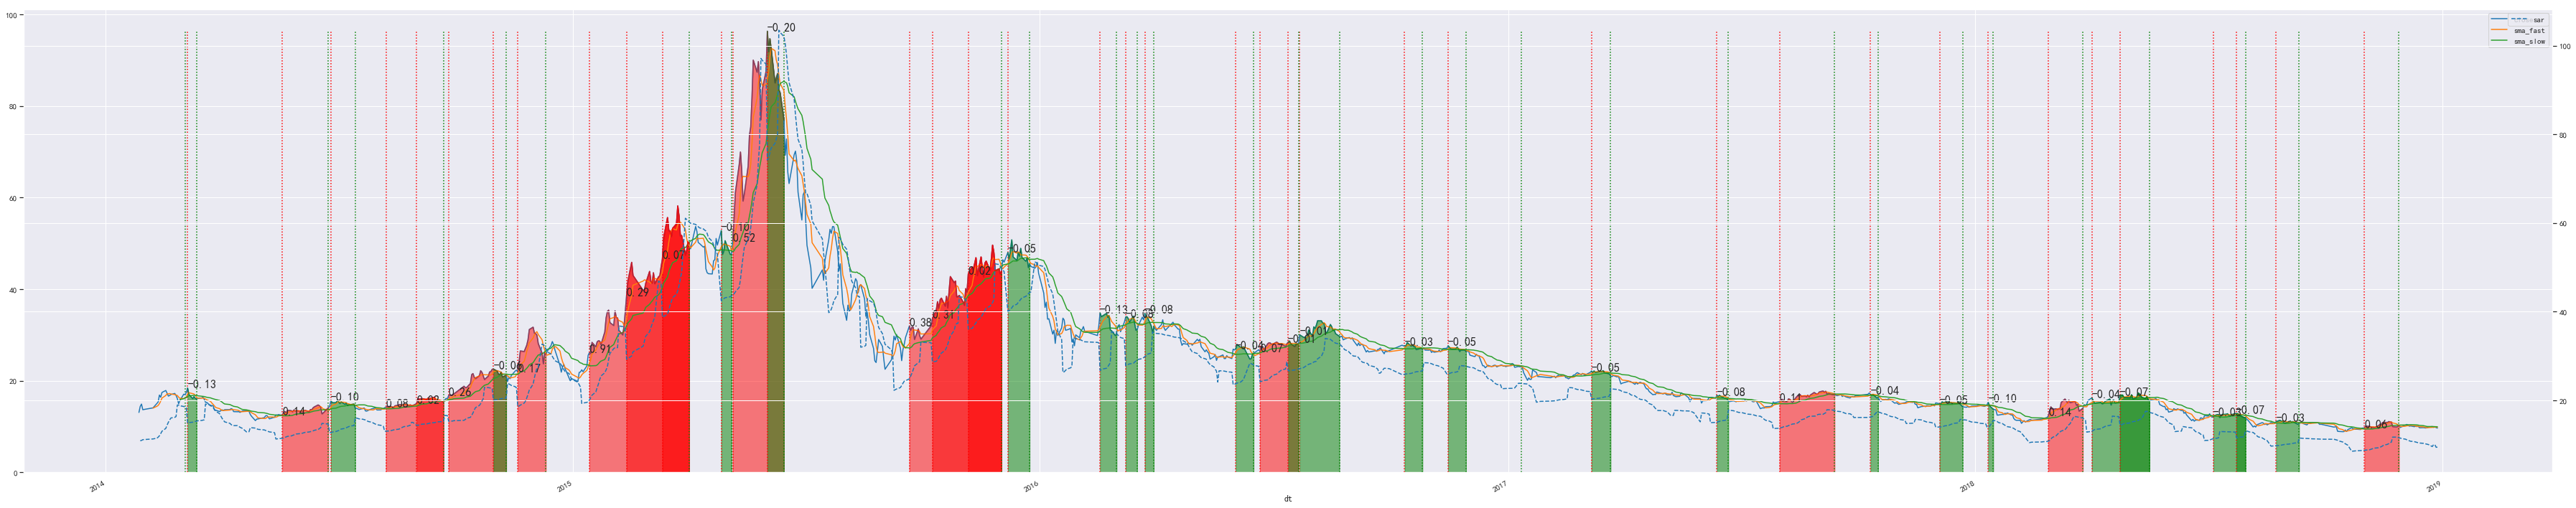

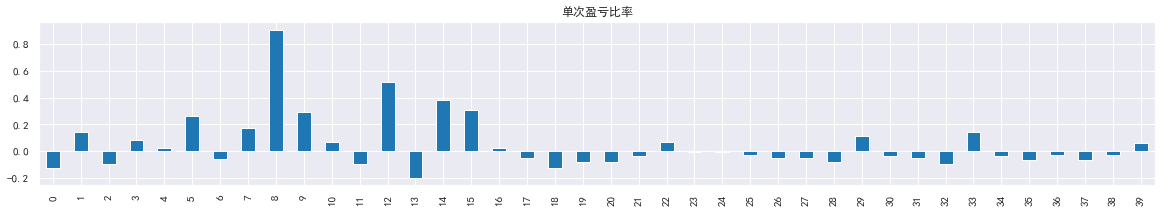

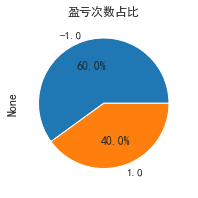

In [506]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')
# simple_data.loc['2014-03-01':'2014-03-31',['close','sar']].plot()
st1=simple_test(simple_data,cols1=['close','sma_fast','sma_slow'],cols2=['sar'])

In [515]:
st1.name="简单测试-{}".format(name)
print(st1.to_frame().round(2).T.to_markdown())

|                                        |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:---------------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-趋向策略-抛物线SAR+双均线交叉 |                   0.22 |           0.91 |                  -0.07 |           -0.2 |           0.05 |         40 |     1198 |           17.8 |                   0.54 |


# 训练回测

## 仓位控制方法

In [480]:
class Position1(abupy.AbuPositionBase):
    """1手"""
    def _init_self(self, **kwargs):
        """子类仓位管理针对可扩展参数的初始化"""
        pass

    def fit_position(self, factor_object):
        return 100

## 回测方法

In [481]:
def backtest(buy_factors,sell_factors,init_cash=10000,**kwargs):
    start = kwargs.pop('start','2014-01-01')
    end = kwargs.pop('end','2018-12-31')

    benchmark = abupy.AbuBenchmark('300378', start, end)
    capital = abupy.AbuCapital(init_cash, benchmark)
    klmanager=kwargs.pop('klmanager',KLManager)
    orders_pd, action_pd, _ = abupy.ABuPickTimeExecute.do_symbols_with_same_factors(
        ['300378'],
        benchmark,
        buy_factors,
        sell_factors,
        capital,
        kl_pd_manager=klmanager(benchmark, capital),
        show=False)
    m = gquant.Metrics(orders_pd, action_pd, capital, benchmark)
    m.fit_metrics()
    if hasattr(m, 'act_sell') and not m.act_sell.empty:
        m.act_sell['profit_init']=m.act_sell['profit'] / m.capital.read_cash
        m.act_sell['profit_init_hunder'] = m.act_sell['profit_init'] * 100
        return m
    return None

## 扩展回测报告

In [520]:
def get_report(m,name):
    p=m.profit_series(name='回测-{}'.format(name))
    p['平均获利期望'] = m.gains_mean  #平均获利期望\n",
    p['平均亏损期望'] = m.losses_mean  #平均亏损期望\n",
    p['盈亏比'] = m.win_loss_profit_rate  #盈亏比\n",
    p['策略年化收益'] = m.algorithm_annualized_returns  #策略年化收益\n",
    p['基准年化收益'] = m.benchmark_annualized_returns  #基准年化收益\n",
    c = m.order_has_ret
    p['赢利交易平均持股天数'] = c[c.profit > 0].keep_days.values.mean()  #赢利交易平均持股天数\n",
    p['亏损交易平均持股天数'] = c[c.profit <= 0].keep_days.values.mean()  #亏损交易平均持股天数\n",
    p = gquant.pd.to_numeric(p)
    return p.to_frame().round(2).T

## 回测结果绘图

In [482]:
def plot_cum_returns(metrics):
    metrics.benchmark_cum_returns.plot()
    metrics.algorithm_cum_returns.plot()
    gquant.plt.legend(['基准收益', '策略收益'], loc='best')
    gquant.plt.title('收益对比')
    gquant.plt.show()

def plot_win_loss_pie(metrics):
    gquant.plt.pie(x=[len(metrics.ret), len(metrics.los)],
                   labels=['盈利', '亏损'],
                   colors=['#d62728', '#2ca02c'],
                   autopct='%1.2f%%')
    gquant.plt.title('盈亏次数比')
    gquant.plt.show()
    
def plot_win_loss_bar(metrics,v='profit_cg_hunder'):
    import matplotlib.ticker
    vc=gquant.np.round(metrics.act_sell[v],0).value_counts().sort_index().to_frame()
    ax=vc.plot(kind='bar',title='盈亏百分比次数')
#     gquant.plt.axvline(x=gquant.np.where(vc.index.to_numpy()==0)[0], color='#d68a27')
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    gquant.plt.show()
    
def plot_capital_blance(metrics):
    metrics.capital.capital_pd.capital_blance.plot(title='账户价值曲线')
    metrics.capital.capital_pd.cash_blance .plot(title='账户现金曲线')
    gquant.plt.xticks(rotation=70)
    gquant.plt.show()

## 原始策略

* 买入：快速均线在慢速均线上方，并且sar在收盘价之下。（不反复开仓）
* 卖出：快速均线在慢速均线下方。（不反复清仓）

- 快速均线：5日
- 慢速均线：20日

- SAR步进值：0.02
- SAR最大值：0.2

- 仓位控制：每次买入100股。（[Position1](#%E4%BB%93%E4%BD%8D%E6%8E%A7%E5%88%B6%E6%96%B9%E6%B3%95)）
- 总资金：10000元
- 回测时间段：2014-01-01 ~ 2018-12-31

|                                    |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:-----------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-趋向策略-抛物线SAR+双均线交叉 |    9065.55 |      16315 |         38 |         15 |         23 |       0.39 |               166.13 |               604.37 |              -119.68 | 1.39 |      -0.16 |        2436.23 |           0.19 |          -0.06 |     1.97 |           0.13 |          -0.05 |                  37.88 |                  14.43 |

### 买卖策略

In [483]:
class BuyStrategy1(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if today['buy']==1:
            return self.buy_tomorrow()
        return None
    
class SellStrategy1(gquant.abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def support_direction(self):
        """支持的方向，只支持正向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        if today['sell']==1:
            for order in orders:
                self.sell_tomorrow(order)

In [508]:
# 买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]

bt1 = backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=26268 begin work'), FloatProgress(value=0.0)))

### 结果

In [530]:
print(get_report(bt1,name).to_markdown())

|                                    |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:-----------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-趋向策略-抛物线SAR+双均线交叉 |    9065.55 |      16315 |         38 |         15 |         23 |       0.39 |               166.13 |               604.37 |              -119.68 | 1.39 |      -0.16 |        2436.23 |           0.19 |          -0.06 |     1.97 |           0.13 |          -0.05 |                  37.88 |                  14.43 |


~~### 结果绘图~~

In [433]:
# plot_cum_returns(bt1)
# plot_capital_blance(bt1)
# plot_win_loss_bar(bt1)
# bt1.plot_max_draw_down()
# bt1.plot_keep_days()
# bt1.plot_effect_mean_day()
# bt1.plot_action_buy_cost()

~~### 获利期望~~

In [434]:
# bt1.plot_returns_cmp()

## 增加1ATR加仓/止损

加仓条件：

- 快速均线高于慢速均线（趋势向上）
- SAR在收盘价以下
- 当前收盘价超过当前持仓价+开仓日当日atr

止损条件：

- 当前收盘价低于当前持仓价-开仓日当日atr

由于增加了加仓操作，所以交易次数增加了（盈亏次数均增加）。虽然看上去总盈利有所增加。但是由于有加仓的存在，所以加仓的部分会更容易回吐部分利润或者造成亏损交易，所以赢利交易平均盈利额有所降低，同时亏损交易平均亏损额增加。从而造成了R值的降低。

|                                                           |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:----------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-回测-趋向策略-抛物线SAR+双均线交叉-增加1ATR加仓/止损 |    13131.6 |    18423.5 |         61 |         25 |         36 |       0.41 |               138.05 |               525.27 |              -130.86 | 1.05 |      -0.21 |        2434.42 |           0.16 |          -0.07 |     1.52 |           0.18 |          -0.05 |                   37.4 |                  14.65 |

In [510]:
class BuyStrategy2(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if self.orders:
            o=self.orders[-1]
            if o.sell_date is None:
                buy=self.kl_pd[self.kl_pd['date']==o.buy_date]#最后一次购买当日的信息
                atr=buy.iloc[0]['atr']#最后一次购买当日的atr数据
                if today['close']>today['sar'] and today['sma_fast']>today['sma_slow'] and today['close']>=(o.buy_price+atr):
#                 if today['close']>today['sar'] and today['sma_fast']>today['sma_slow'] and today['close']>=o.buy_price+today['atr']:
                    return self.buy_tomorrow()
        return None

class SellStrategy2(abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.sell_type_extra = self.__class__.__name__
        
    def support_direction(self):
        return [abupy.ESupportDirection.DIRECTION_CAll.value]
    
    def fit_day(self, today, orders):
        for order in orders:
            if order.sell_date is None:
                buy=self.kl_pd[self.kl_pd['date']==order.buy_date]#最后一次购买当日的信息
                atr=buy.iloc[0]['atr']#最后一次购买当日的atr数据
                if (order.buy_price-atr)>=today.close:
                    self.sell_tomorrow(order)
   
#买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
    {
        'class': BuyStrategy2,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
#     {
#     'class': SellStrategy2,
# }
]

bt2 = backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=26268 begin work'), FloatProgress(value=0.0)))

In [527]:
print(get_report(bt2,'回测-{}-增加1ATR加仓/止损'.format(name)).to_markdown())

|                                                           |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |   平均获利期望 |   平均亏损期望 |   盈亏比 |   策略年化收益 |   基准年化收益 |   赢利交易平均持股天数 |   亏损交易平均持股天数 |
|:----------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------:|
| 回测-回测-趋向策略-抛物线SAR+双均线交叉-增加1ATR加仓/止损 |    13131.6 |    18423.5 |         61 |         25 |         36 |       0.41 |               138.05 |               525.27 |              -130.86 | 1.05 |      -0.21 |        2434.42 |           0.16 |          -0.07 |     1.52 |           0.18 |          -0.05 |                   37.4 |                  14.65 |


In [528]:
gquant.pd.concat([get_report(bt1,'回测-{}'.format(name)),
                  get_report(bt2,'回测-{}-增加1ATR加仓/止损'.format(name))
                 ])

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费,平均获利期望,平均亏损期望,盈亏比,策略年化收益,基准年化收益,赢利交易平均持股天数,亏损交易平均持股天数
回测-回测-趋向策略-抛物线SAR+双均线交叉,9065.55,16314.97,38.0,15.0,23.0,0.39,166.13,604.37,-119.68,1.39,-0.16,2436.23,0.19,-0.06,1.97,0.13,-0.05,37.88,14.43
回测-回测-趋向策略-抛物线SAR+双均线交叉-增加1ATR加仓/止损,13131.65,18423.53,61.0,25.0,36.0,0.41,138.05,525.27,-130.86,1.05,-0.21,2434.42,0.16,-0.07,1.52,0.18,-0.05,37.40,14.65
